In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale

import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

import torch
from torch import nn

from pt_lstm import LSTM

%matplotlib inline

In [5]:
sns.set_style('darkgrid')

In [6]:
df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1435968000&period2=1593820800&interval=1d&events=history")

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-04,256.490997,261.457001,254.199997,260.885986,260.885986,15620400
1,2015-07-05,260.804993,274.506012,258.700989,271.912994,271.912994,44156100
2,2015-07-06,271.108002,277.421997,267.600006,269.029999,269.029999,49154800
3,2015-07-07,269.963013,271.341003,264.832001,266.207001,266.207001,28857600
4,2015-07-08,265.981995,272.971008,264.385986,270.785004,270.785004,36980200


In [8]:
close = df['Close'][500:-1]

# of data points:  1327


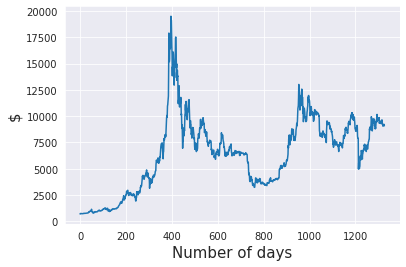

In [9]:
print("# of data points: ", close.size)

plt.plot(range(close.size), close)

plt.xlabel("Number of days", size = 15)
plt.ylabel("$", size = 15);

In [10]:
# Transfrom the data
mm_scaler = MinMaxScaler(feature_range = (-1, 1))
close_norm = mm_scaler.fit_transform(close.values.reshape(-1, 1))

# Train-test split
n_split = 950

train_data = close[:n_split]
test_data = close[n_split:]

train_data_norm = close_norm[:n_split]
test_data_norm = close_norm[n_split:]

print("Successful split: ", len(train_data_norm) + len(test_data_norm) == len(close))

# Convert to tensor
train_data_norm = torch.FloatTensor(train_data_norm).view(-1)
test_data_norm = torch.FloatTensor(test_data_norm).view(-1)

Successful split:  True


In [11]:
def window_func(input_data, window_size):
    
    """
    
    """
    
    input_seq = []
    L = len(input_data)
    
    for i in range(L - window_size):
        
        train_seq = input_data[i: i + window_size]
        train_label = input_data[i + window_size: i + window_size + 1]
        
        input_seq.append((train_seq, train_label))
        
    return input_seq


In [12]:
window_size = 7

train_input_seq = window_func(train_data_norm, window_size)
test_input_seq = window_func(test_data_norm, window_size)

y_train = np.array([train_input_seq[i][1] for i in range(len(train_input_seq))])
y_test = np.array([test_input_seq[i][1] for i in range(len(test_input_seq))])

In [13]:
y_train = np.array([train_input_seq[i][1] for i in range(len(train_input_seq))])
y_test = np.array([test_input_seq[i][1] for i in range(len(test_input_seq))])

In [14]:
# Hyperparameters 
input_size = 1
output_size = 1
hidden_dim = 5

# Loss function
criterion = nn.MSELoss()

lstm = LSTM(input_size, output_size, hidden_dim, lh = [])

lstm = lstm.train_(input_size, output_size, hidden_dim,
                     train_input_seq, criterion, lh = [],
                     n_epochs = 100, verbose = True, print_i = 20)

Epoch 0  Loss:  0.0473652109503746
Epoch 20  Loss:  0.004494836553931236
Epoch 40  Loss:  0.0029028584249317646
Epoch 60  Loss:  0.003042292082682252
Epoch 80  Loss:  0.0032661824952811003


In [15]:
len(lstm.loss_hist)

100

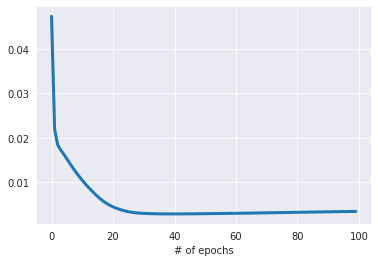

In [19]:
plt.plot(lstm.loss_hist, lw = 3)
plt.xlabel("# of epochs");

In [23]:
y_hat_norm = []

lstm.eval()

with torch.no_grad():

    for seq, _ in test_input_seq:
    
    #with torch.no_grad():
        
        lstm.hidden_cell = (torch.zeros(1, 1, lstm.hidden_dim),
                             torch.zeros(1, 1, lstm.hidden_dim))
        
        y_hat_norm.append(lstm(seq).item())
        
y_hat_norm = np.array(y_hat_norm)
y_hat_orig = mm_scaler.inverse_transform(y_hat_norm.reshape(-1, 1))

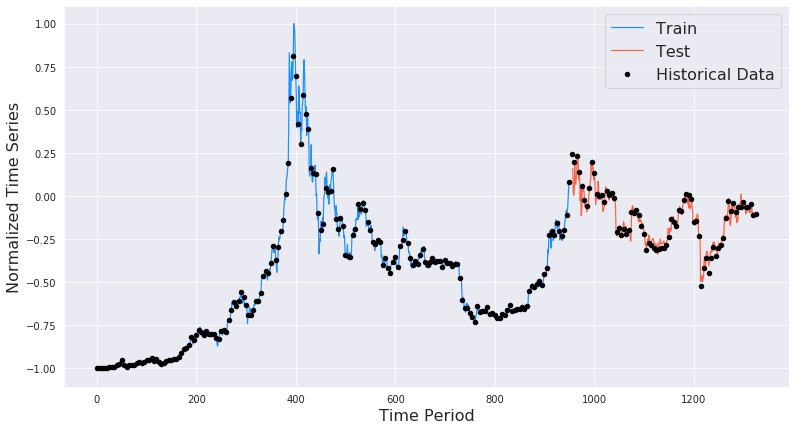

In [24]:
plt.figure(figsize = (13, 7))

plt.scatter(range(close_norm.shape[0])[::5], close_norm[::5], s = 20,
            color = 'k', zorder = 10, label = 'Historical Data')

plt.plot(np.arange(window_size, y_train.size + window_size), y_train,
        lw = 1.2, c = 'dodgerblue', label = 'Train')

plt.plot(np.arange(window_size+n_split, window_size+n_split + y_hat_norm.size), y_hat_norm,
        lw = 1.2, c = 'tomato', label = "Test")

plt.xlabel('Time Period', size = 16)
plt.ylabel('Normalized Time Series', size = 16)
plt.legend(prop = {'size': 16});

In [26]:
# MSE
np.mean((y_test - y_hat_norm)**2)

0.0016044245548747595

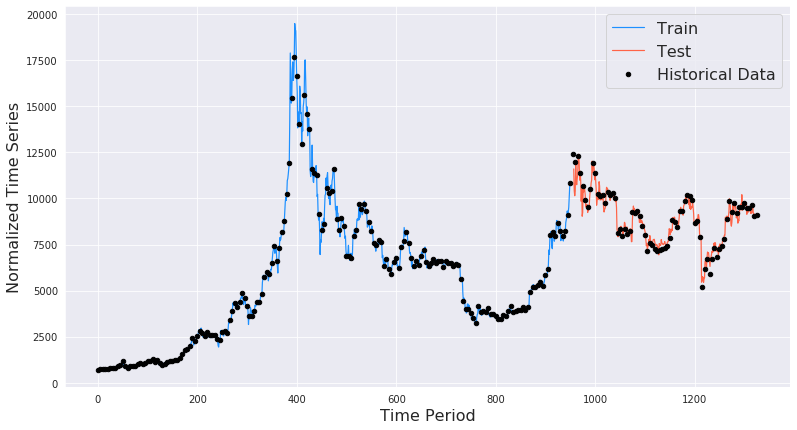

In [28]:
# Original scale
plt.figure(figsize = (13, 7))

plt.scatter(range(close_norm.shape[0])[::5], close[::5], s = 20,
            color = 'k', zorder = 10, label = 'Historical Data')

plt.plot(np.arange(window_size, y_train.size + window_size),
         mm_scaler.inverse_transform(y_train.reshape(-1, 1)),
         lw = 1.2, c = 'dodgerblue', label = 'Train')

plt.plot(np.arange(n_split + window_size, n_split + y_hat_norm.size + window_size),
         y_hat_orig,
         lw = 1.2, c = 'tomato', label = "Test")

plt.xlabel('Time Period', size = 16)
plt.ylabel('Normalized Time Series', size = 16)
plt.legend(prop = {'size': 16});

In [30]:
# fore cast for 3 weeks using the last week data and update based on new prediction
last_seven = list(close.values[-window_size:])
forecast = []

for i in range(21):
    
    lst_wk = np.array(last_seven).reshape(-1, 1)
    lst_wk_norm = mm_scaler.fit_transform(lst_wk)

    lst_wk = torch.FloatTensor(lst_wk_norm)

    ypred = mm_scaler.inverse_transform(lstm(lst_wk).data.numpy().reshape(-1, 1))
    forecast.append((1 + 0.01*np.random.normal()) * ypred[0][0])                  # Add some ranodm noise
    
    del last_seven[0]
    last_seven = last_seven + [ypred[0][0]]

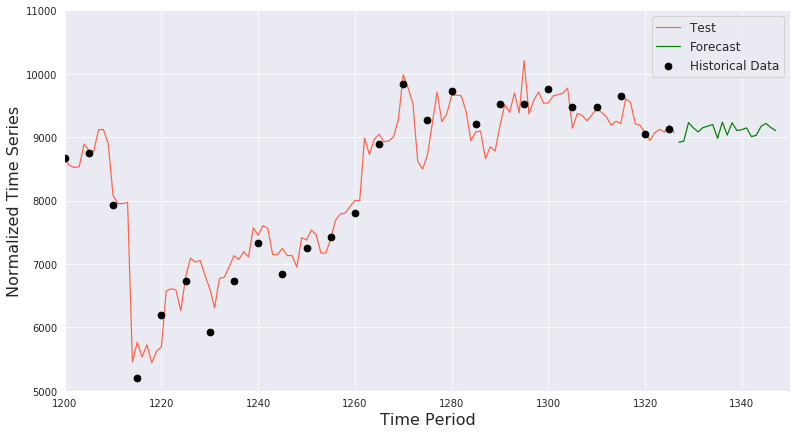

In [36]:
plt.figure(figsize = (13, 7))

plt.scatter(range(close.shape[0])[::5], close[::5], s = 45,
            color = 'k', zorder = 10, label = 'Historical Data')

#plt.plot(np.arange(window_size, y_train.size + window_size), y_train,
#        lw = 1.2, c = 'dodgerblue', label = 'Train')

plt.plot(np.arange(n_split + window_size, n_split + window_size + y_hat_orig.size), y_hat_orig,
        lw = 1.2, c = 'tomato', label = "Test")

plt.plot(np.arange(n_split+window_size+y_hat_orig.size, n_split+window_size+y_hat_orig.size + 21),
         np.array(forecast),
       lw = 1.2, c = 'g', label = "Forecast")

plt.ylim(5000, 11000)
plt.xlim(1200, 1350)
plt.xlabel('Time Period', size = 16)
plt.ylabel('Normalized Time Series', size = 16)
plt.legend(prop = {'size': 12}, loc = "best");